In [ ]:
!pip install memory_profiler

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
import time

In [10]:
class BaseOptimizer:
    def __init__(self, lr, k_reg):
        self.lr = lr
        self.k_reg = k_reg

    def optimize(self, weights, loss_grad, batch_xs, batch_ys):
        gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
        return weights - gradient * self.lr + self.k_reg * weights

    def reset(self):
        pass


class BatchGD:
    def __init__(self, start_point, dim, epochs, loss, loss_grad, lamb=0.4, optimizer=BaseOptimizer(1e-2, 1e-4)):
        self.dim = dim
        self.epochs = epochs
        self.start_point = start_point
        self.weights = start_point
        self.loss = loss
        self.loss_grad = loss_grad
        self.lamb = lamb
        self.optimizer = optimizer
        self.trace_train = []
        self.trace = []

    def train(self, xs, ys, bs, q_precision=1e-5, weights_precision=1e-4, show_loss=True):
        q = self.loss(self.weights, xs, ys).mean()
        losses = []
        for i in range(self.epochs):
            batch_idxs = np.random.choice(np.arange(len(xs)), size=bs, replace=False)
            batch_xs = xs[batch_idxs, :]
            batch_ys = ys[batch_idxs]

            eps = self.loss(self.weights, batch_xs, batch_ys).mean()
            losses.append(q)
            prev_weights = self.weights
            self.trace_train.append(prev_weights)

            self.weights = self.optimizer.optimize(self.weights, self.loss_grad, batch_xs, batch_ys)

            prev_q = q
            q = self.lamb * eps + (1 - self.lamb) * prev_q

            if show_loss:
                print(f'Epoch: {i + 1}. Loss: {q}')

            if np.abs(q - prev_q) < q_precision and np.abs(self.weights - prev_weights).mean() < weights_precision:
                self.trace = np.array(self.trace_train)
                return losses
        self.trace = np.array(self.trace_train)
        return losses

    def reset_weights(self):
         self.weights = self.start_point
         self.trace_train = []
         self.trace = []
         self.optimizer.reset()

    def predict(self, xs):
        return xs @ self.weights

In [11]:
def plot3D(algo, label, show=True):
    w1, w2 = np.mgrid[-3*np.pi:3*np.pi:100j,
                -3*np.pi:3*np.pi:100j]
    w1, w2 = w1.reshape(-1, 1), w2.reshape(-1, 1)
    weights = np.append(w1, w2, axis=1).T
    answers = np.tile(ys.reshape(-1, 1), (1, 10000))
    z = loss(weights, xs, answers).mean(axis=0)

    w1 = w1.reshape(100, 100)
    w2 = w2.reshape(100, 100)
    z = z.reshape(100, 100)

    fig, ax = plt.subplots()

    ax.contour(w1, w2, z, levels=100)

    fig.set_figwidth(8)
    fig.set_figheight(8)

    plt.plot(algo.trace[:, 0], algo.trace[:, 1], '-o', label=label)
    plt.legend()

    if show:
        plt.show()

In [12]:
f = lambda x: -5 * x[:, 0] + 3 * x[:, 1]
loss = lambda weights, xs, ys: (xs @ weights - ys) ** 2
loss_grad = lambda weights, xs, ys: np.array([2 * (xs @ weights - ys) * (xs[:, i]) for i in range(len(weights))])

In [13]:
a, b = -10, 10
xs = (b - a) * np.random.random_sample((200, 2)) + a
ys = f(xs).flatten()

In [14]:
start_point = np.array([0, 0])

### SGD

In [15]:
sgd_algo = BatchGD(start_point, 2, 1000, loss, loss_grad)

In [ ]:
sgd_losses = sgd_algo.train(xs, ys, 1)

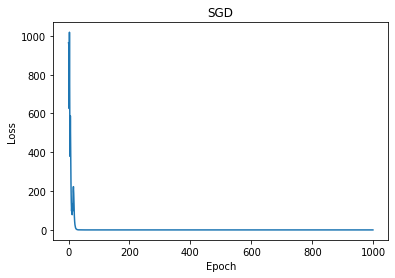

In [18]:
plt.plot(sgd_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD')
plt.show()

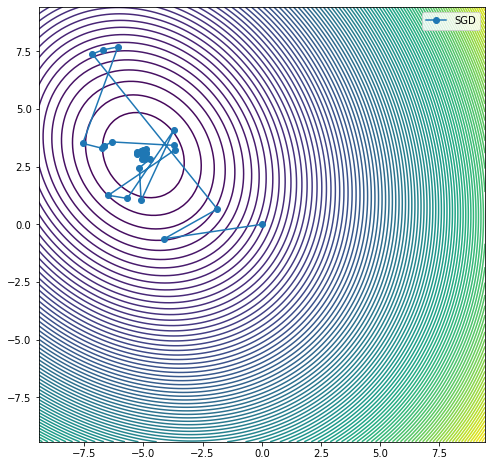

In [19]:
plot3D(sgd_algo, 'SGD')

In [20]:
sgd_algo.weights

array([-5.00071785,  3.00273751])

### Minibatch (20)

In [21]:
minibatch_algo = BatchGD(start_point, 2, 1000, loss, loss_grad)

In [ ]:
minibatch_losses = minibatch_algo.train(xs, ys, bs=40)

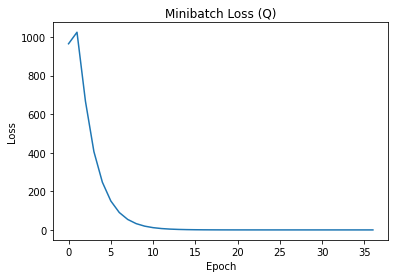

In [23]:
plt.plot(minibatch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Minibatch Loss (Q)')
plt.show()

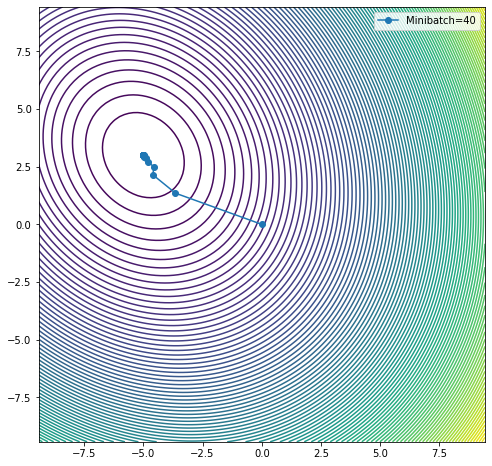

In [24]:
plot3D(minibatch_algo, 'Minibatch=40')

### Batch (full dataset)

In [28]:
batch_algo = BatchGD(start_point, 2, 1000, loss, loss_grad, 1.0)

In [ ]:
batch_losses = batch_algo.train(xs, ys, bs=100)

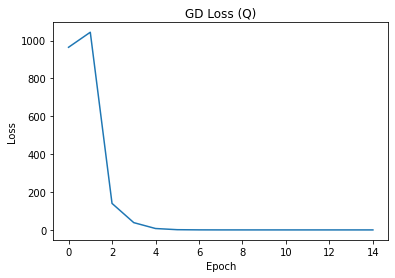

In [30]:
plt.plot(batch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GD Loss (Q)')
plt.show()

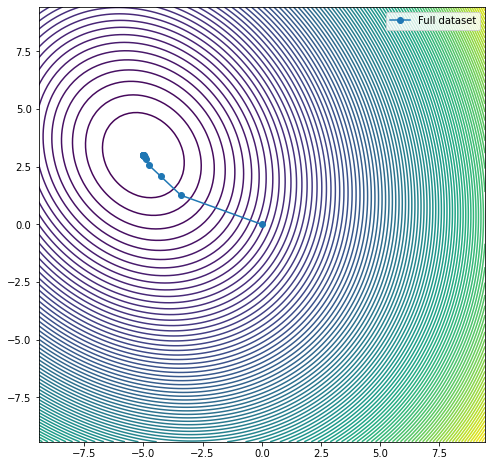

In [31]:
plot3D(batch_algo, 'Full dataset')

In [32]:
scaled = xs.copy()
scaled[:, 0] = (scaled[:, 0] - scaled[:, 0].mean(axis=0)) / scaled[:, 0].std(axis=0)
ys_scaled = f(scaled).flatten()

In [ ]:
sgd_algo_scaled = BatchGD(start_point, 2, 1000, loss, loss_grad)
sgd_losses_scaled = sgd_algo_scaled.train(scaled, ys_scaled, 1)

Text(0.5, 1.0, 'SGD Loss (Scaled) (Q)')

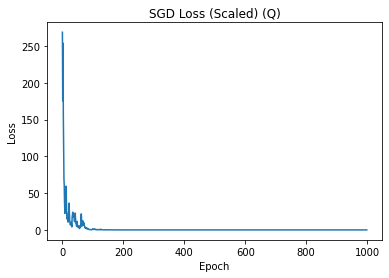

In [34]:
plt.plot(sgd_losses_scaled)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Loss (Scaled) (Q)')

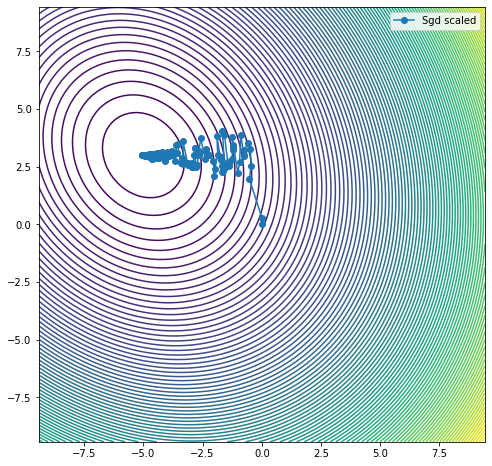

In [35]:
plot3D(sgd_algo_scaled, 'Sgd scaled')

## Nesterov 

In [ ]:
class NesterovOptimizer:
  def __init__(self,lr=1e-3, gamma=0.9):
    self.v = 0
    self.lr = lr
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights - self.gamma * self.v, batch_xs, batch_ys).mean(axis=1)
    self.v = self.gamma * self.v + gradient * self.lr
    return weights - self.v
  def reset(self):
        self.v = 0

optimizer = NesterovOptimizer()
sgd_nesterov_algo = BatchGD(start_point, 2, 1000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_nesterov_losses = sgd_nesterov_algo.train(xs, ys, 1)

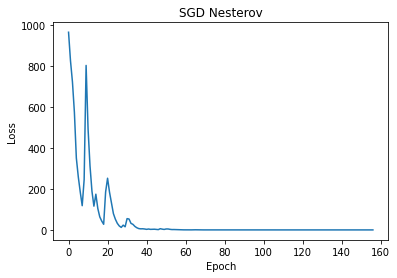

In [37]:
plt.plot(sgd_nesterov_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Nesterov')
plt.show()

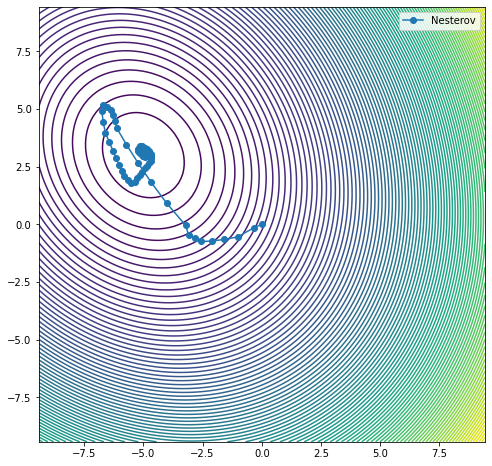

In [38]:
plot3D(sgd_nesterov_algo, 'Nesterov')

## Momentum

In [ ]:
class MomentumOptimizer:
  def __init__(self,lr=1e-3, gamma=0.9):
    self.v = 0
    self.lr = lr
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.v = self.gamma * self.v + gradient * self.lr
    return weights - self.v

  def reset(self):
      self.v = 0

optimizer = MomentumOptimizer()
sgd_momentum_algo = BatchGD(start_point, 2, 1000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_monentum_losses = sgd_momentum_algo.train(xs, ys, 1)

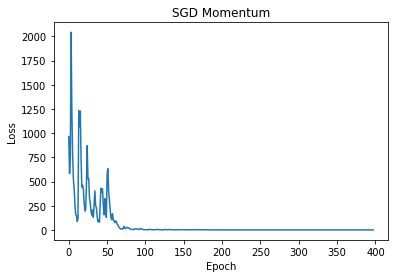

In [40]:
plt.plot(sgd_monentum_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Momentum')
plt.show()

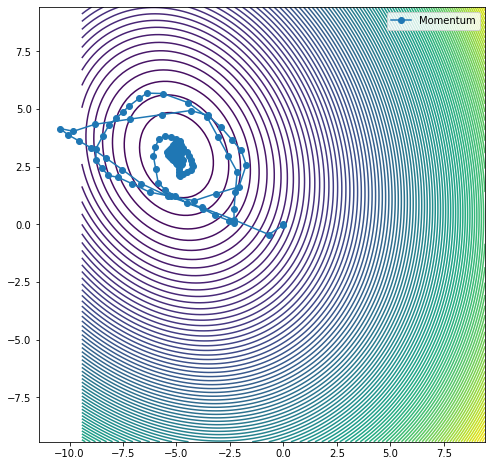

In [41]:
plot3D(sgd_momentum_algo, 'Momentum')

## AdaGrad

In [ ]:
%%time
class AdaGradOptimizer:
  def __init__(self,lr=9e-1, eps = 1e-8):
    self.G = 0
    self.lr = lr
    self.eps = eps

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.G += gradient ** 2
    return weights - self.lr * gradient / np.sqrt(self.G + self.eps)

  def reset(self):
      self.G = 0

optimizer = AdaGradOptimizer()
sgd_adagrad_algo = BatchGD(start_point, 2, 20000, loss, loss_grad, lamb=0.8, optimizer=optimizer)

sgd_adagrad_losses = sgd_adagrad_algo.train(xs, ys, 1)

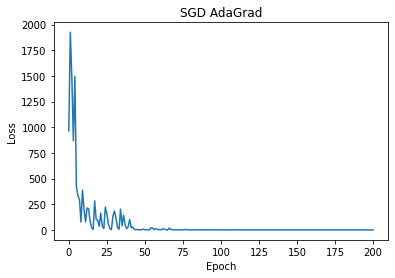

In [43]:
plt.plot(sgd_adagrad_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD AdaGrad')
plt.show()

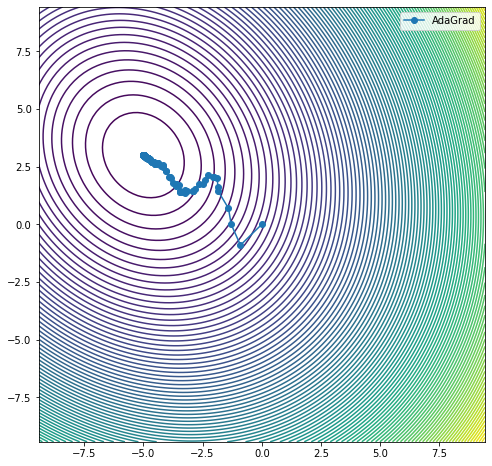

In [44]:
plot3D(sgd_adagrad_algo, 'AdaGrad')

## RMSProp

In [ ]:
%%time
class RMSPropOptimizer:
  def __init__(self,lr=1e-1, eps = 1e-7, gamma=0.9):
    self.G = 0
    self.lr = lr
    self.eps = eps
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.G = self.G * self.gamma + (1 - self.gamma) * (gradient ** 2)
    return weights - self.lr * gradient / np.sqrt(self.G + self.eps)

  def reset(self):
      self.G = 0

optimizer = RMSPropOptimizer()
sgd_rmsprop_algo = BatchGD(start_point, 2, 20000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_rmsprop_losses = sgd_rmsprop_algo.train(xs, ys, 1)

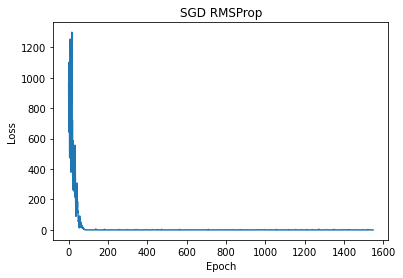

In [46]:
plt.plot(sgd_rmsprop_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD RMSProp')
plt.show()

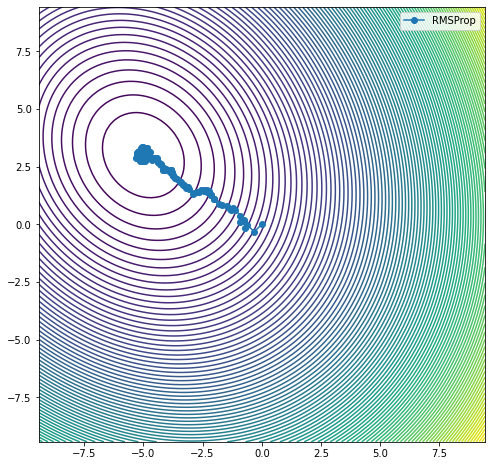

In [47]:
plot3D(sgd_rmsprop_algo, 'RMSProp')

## Adam

In [ ]:
%%time
class AdamOptimizer:
  def __init__(self,lr=5e-1, eps = 1e-8, b_1=0.9, b_2=0.999):
    self.m = 0
    self.v = 0
    self.lr = lr
    self.eps = eps
    self.b_1 = b_1
    self.b_2 = b_2
    self.t = 1

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)

    self.m = self.m * self.b_1 + (1 - self.b_1) * gradient
    self.v = self.v * self.b_2 + (1 - self.b_2) * (gradient ** 2)

    self.t += 1

    m_t = self.m/(1 - self.b_1**self.t)
    v_t = self.v/(1 - self.b_2**self.t)

    return weights - self.lr * m_t / (np.sqrt(v_t) + self.eps)

  def reset(self):
      self.m = 0
      self.v = 0
      self.t = 1

optimizer = AdamOptimizer()
sgd_adam_algo = BatchGD(start_point, 2, 10000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_adam_losses = sgd_adam_algo.train(xs, ys, 1)

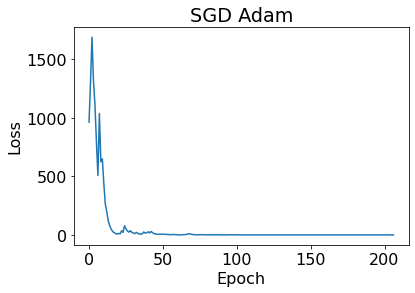

In [85]:
plt.plot(sgd_adam_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Adam')
plt.show()

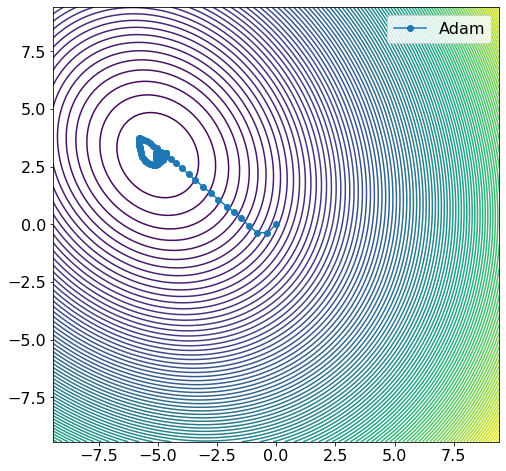

In [86]:
plot3D(sgd_adam_algo, 'Adam')

## Сравнение алгоритмов

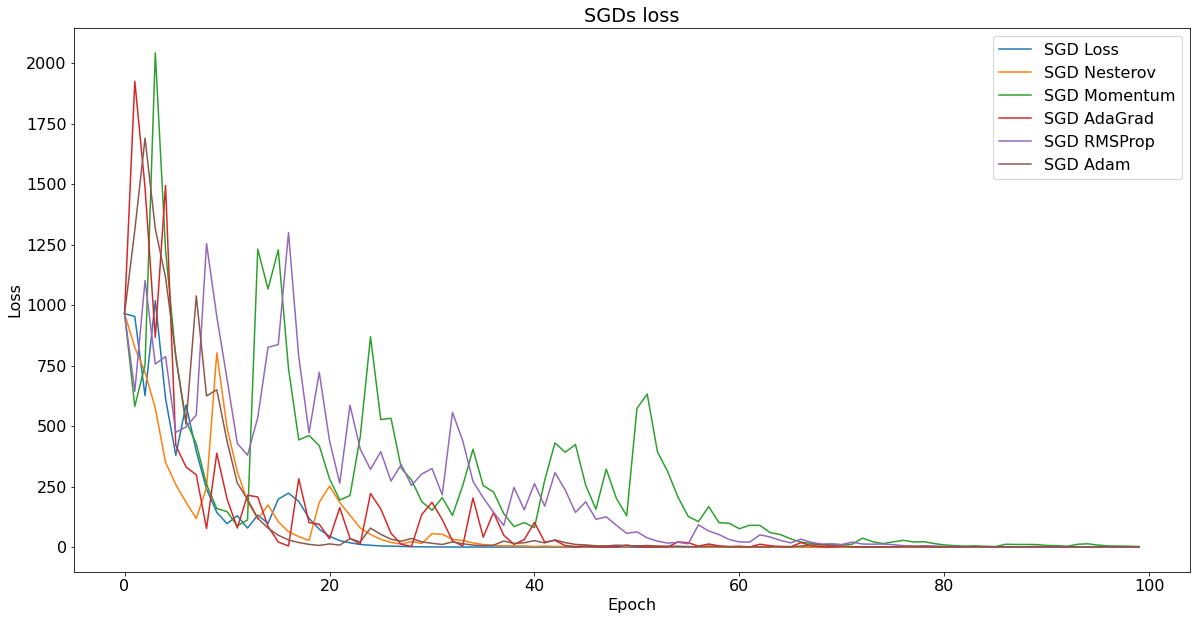

In [92]:
plt.figure(figsize=(20, 10))
plt.plot(sgd_losses[:100], label='SGD Loss')
plt.plot(sgd_nesterov_losses[:100], label='SGD Nesterov')
plt.plot(sgd_monentum_losses[:100], label='SGD Momentum')
plt.plot(sgd_adagrad_losses[:100], label='SGD AdaGrad')
plt.plot(sgd_rmsprop_losses[:100], label='SGD RMSProp')
plt.plot(sgd_adam_losses[:100], label='SGD Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGDs loss')
plt.legend()
plt.show()

count iterations : [1000, 157, 398, 201, 1548, 207]
used memory : [231.859375, 231.86328125, 231.86328125, 231.86328125, 231.8671875, 232.5703125]
work time : [0.11568689346313477, 0.14412140846252441, 0.0877370834350586, 0.06802153587341309, 0.13321638107299805, 0.10008502006530762]


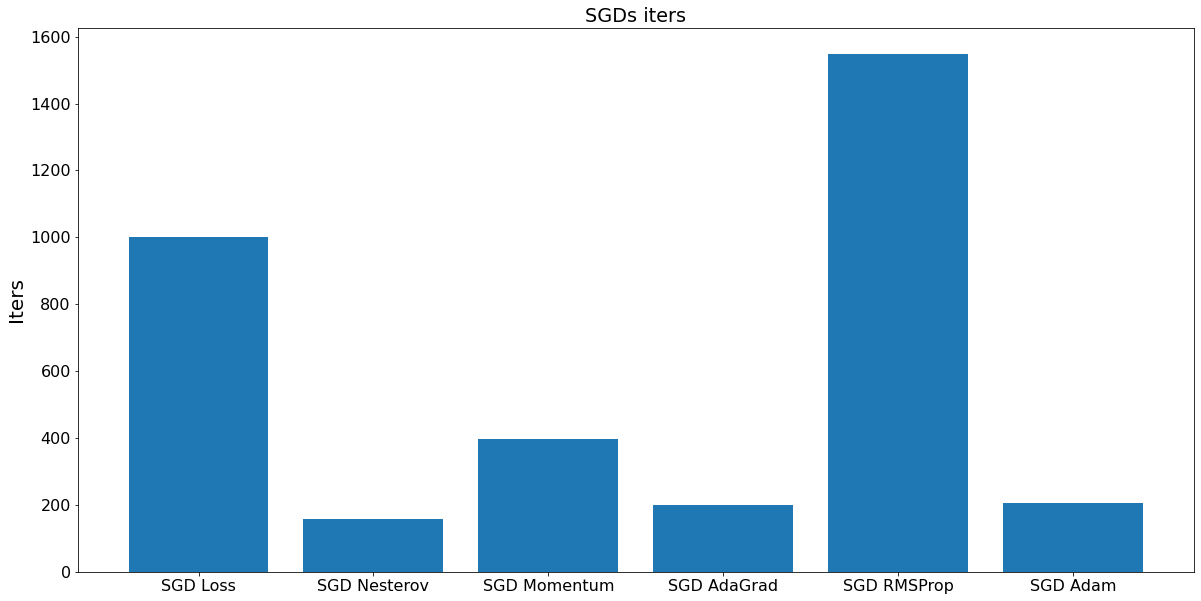

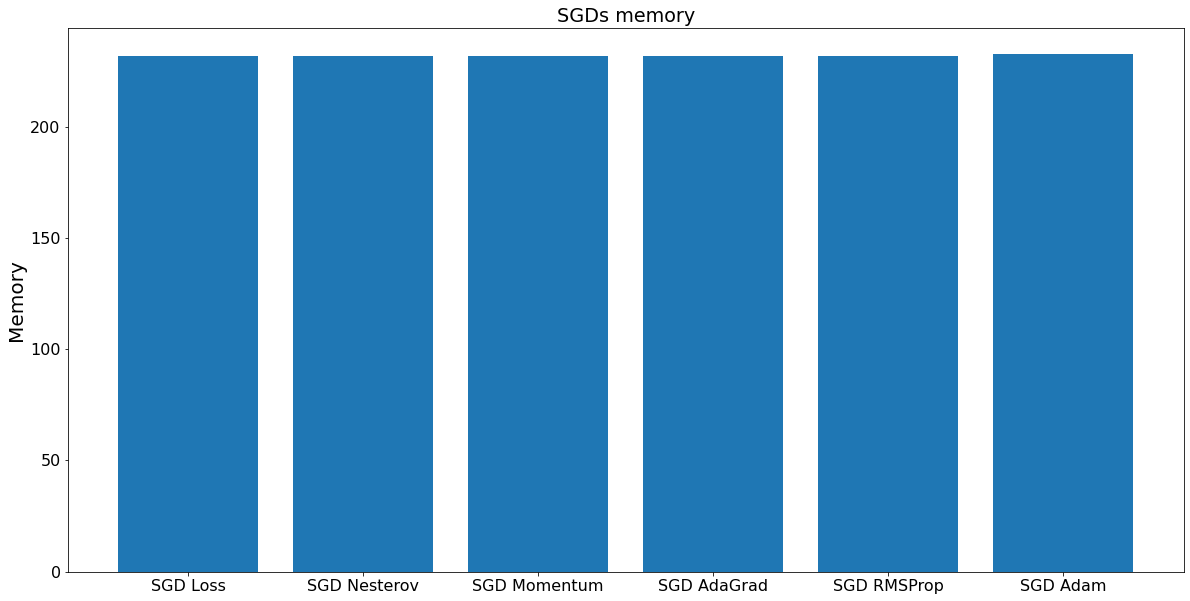

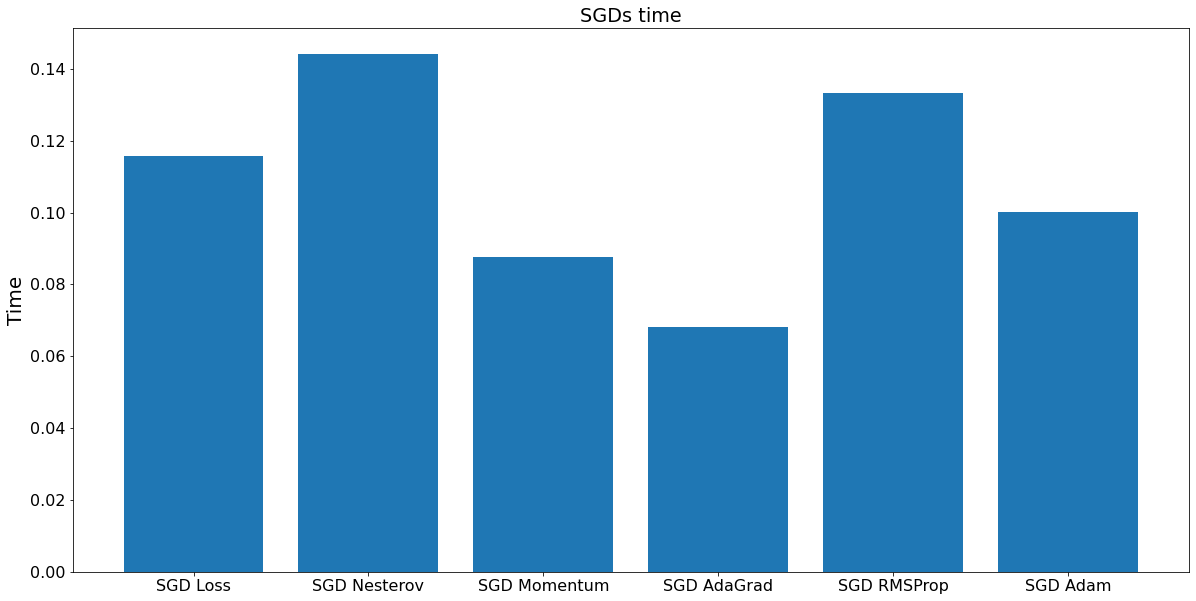

In [93]:
algos_names = ['SGD Loss', 'SGD Nesterov', 'SGD Momentum', 'SGD AdaGrad', 'SGD RMSProp', 'SGD Adam']
count_iters = [len(sgd_losses), len(sgd_nesterov_losses), len(sgd_monentum_losses), len(sgd_adagrad_losses),
               len(sgd_rmsprop_losses), len(sgd_adam_losses)]
algos = [sgd_algo, sgd_nesterov_algo, sgd_momentum_algo, sgd_adagrad_algo, sgd_rmsprop_algo, sgd_adam_algo]
memories = []
times = []
for algo in algos:
    algo.reset_weights()
    cur_time = time.time()
    (memory, exe_time) = memory_usage((algo.train, (xs, ys, 1,), {'show_loss': False}), timestamps=True)[0]
    memories.append(memory)
    times.append(exe_time - cur_time)

plt.rcParams.update({'font.size': 16})

print('count iterations : ' + str(count_iters))
print('used memory : ' + str(memories))
print('work time : ' + str(times))

plt.figure(figsize=(20, 10))
plt.title('SGDs iters')
plt.ylabel('Iters', fontsize=20)
plt.bar(algos_names, count_iters)
plt.show()

plt.figure(figsize=(20, 10))
plt.title('SGDs memory')
plt.ylabel('Memory', fontsize=20)
plt.bar(algos_names, memories)
plt.show()

plt.figure(figsize=(20, 10))
plt.title('SGDs time')
plt.ylabel('Time', fontsize=20)
plt.bar(algos_names, times)
plt.show()

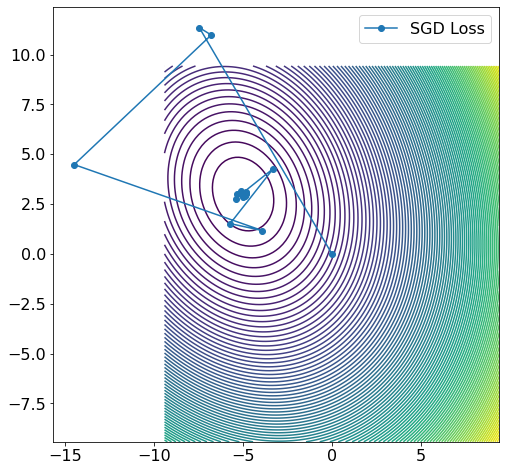

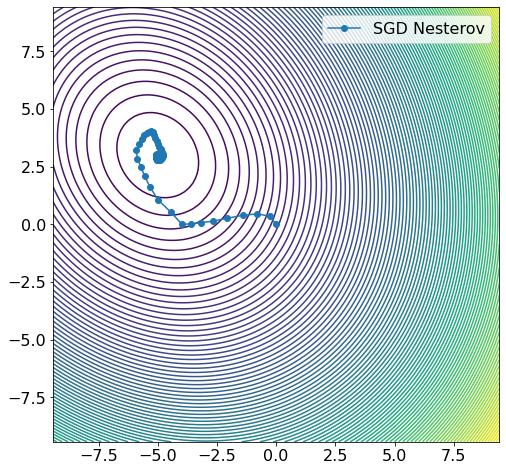

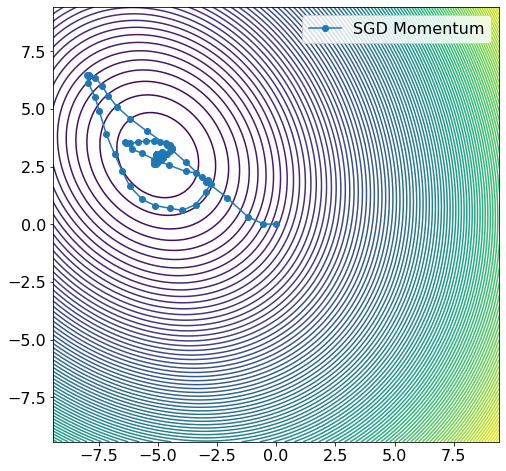

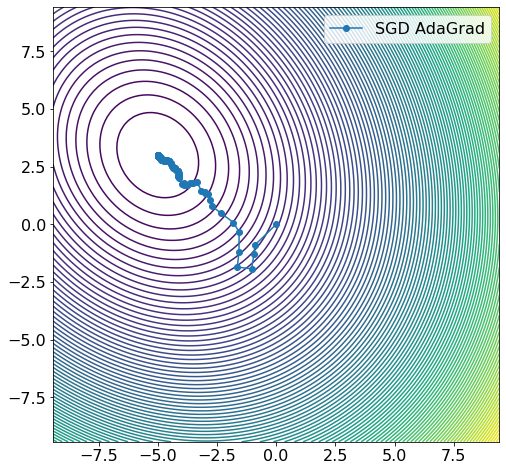

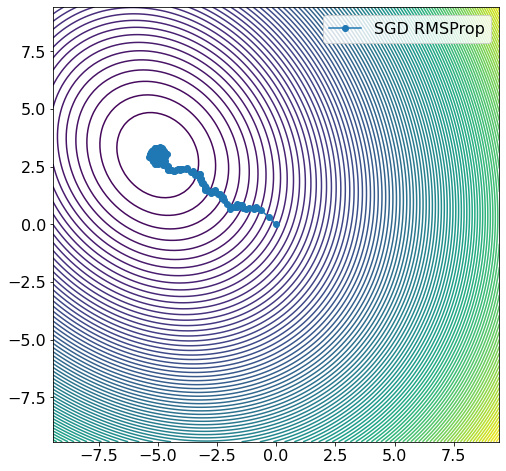

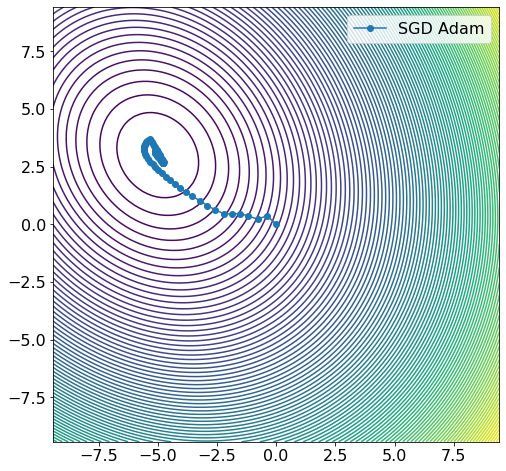

In [94]:
for algo, label in zip(algos, algos_names):
    plot3D(algo, label, False)
plt.show()